In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """Simple double convolution block with normalization and activation"""
    
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class SimpleUNet(nn.Module):
    """Simplified U-Net for bead classification"""
    
    def __init__(self, n_classes=4):
        super().__init__()
        self.n_classes = n_classes
        
        # Encoder (downsampling)
        self.enc1 = ConvBlock(3, 32)
        self.enc2 = ConvBlock(32, 64)
        self.enc3 = ConvBlock(64, 128)
        
        # Bottleneck
        self.bottleneck = ConvBlock(128, 256)
        
        # Decoder (upsampling)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = ConvBlock(256, 128)
        
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)
        
        # Final layer
        self.final = nn.Conv2d(32, n_classes, 1)
        self.dropout = nn.Dropout2d(0.2)
        
        # Pooling
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e3))
        b = self.dropout(b)
        
        # Decoder with skip connections
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Final output
        out = self.final(d1)
        return out


# Example usage
if __name__ == "__main__":
    # Create simplified model
    model = SimpleUNet(n_classes=4)  # 10 bead classes
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test with sample input
    x = torch.randn(2, 3, 256, 256)  # batch_size=2, channels=3, height=256, width=256
    
    model.eval()
    with torch.no_grad():
        output = model(x)
        predictions = torch.argmax(output, dim=1)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Predictions shape: {predictions.shape}")
    
    # Training example
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Dummy training step
    target = torch.randint(0, 4, (2, 256, 256))
    
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    print(f"Training loss: {loss.item():.4f}")
    
    print("\nSimplified U-Net Features:")
    print("- 3 encoder/decoder levels (vs 4 in full U-Net)")
    print("- Fewer channels: 32→64→128→256 (vs 64→128→256→512→1024)")
    print("- Instance normalization for small datasets")
    print("- Simple skip connections")
    print("- Dropout for regularization")
    print("- ~10x fewer parameters than full U-Net")

Model parameters: 1,927,108
Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 4, 256, 256])
Predictions shape: torch.Size([2, 256, 256])
Training loss: 1.4538

Simplified U-Net Features:
- 3 encoder/decoder levels (vs 4 in full U-Net)
- Fewer channels: 32→64→128→256 (vs 64→128→256→512→1024)
- Instance normalization for small datasets
- Simple skip connections
- Dropout for regularization
- ~10x fewer parameters than full U-Net


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import defaultdict
import time
import random


class BeadDataset(Dataset):
    """Custom dataset for bead segmentation"""
    
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        
        # Get all image files
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Handle mask file extension - try same extension as image first
        mask_path = os.path.join(self.mask_dir, img_name)  # Same extension as image
        if not os.path.exists(mask_path):
            # Try different common extensions
            base_name = os.path.splitext(img_name)[0]  # Remove extension
            for ext in ['.png', '.jpg', '.jpeg']:
                mask_path = os.path.join(self.mask_dir, base_name + ext)
                if os.path.exists(mask_path):
                    break
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale mask
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        
        return image, mask


class DiceScore(nn.Module):
    """Dice coefficient for segmentation evaluation"""
    
    def __init__(self, num_classes, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice_scores = []
        
        for i in range(self.num_classes):
            pred_i = pred[:, i]
            target_i = (target == i).float()
            
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()
            
            dice = (2 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)
        
        return torch.stack(dice_scores).mean()


class SqueezeToLong:
    """Custom transform to replace lambda for multiprocessing compatibility"""
    def __call__(self, x):
        return x.squeeze().long()


class SegmentationTrainer:
    """Complete training pipeline for SimpleUNet"""
    
    def __init__(self, model, device, train_loader, val_loader, n_classes=4):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_classes = n_classes
        
        # Ensure model uses GPU efficiently
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            if torch.cuda.device_count() > 1:
                self.model = nn.DataParallel(self.model)
        
        # Loss functions
        self.criterion = nn.CrossEntropyLoss()
        self.dice_metric = DiceScore(n_classes)
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=1e-3, 
            weight_decay=1e-4
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5
        )
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'lr': []
        }
        
        # Best model tracking
        self.best_dice = 0.0
        self.best_model_state = None
        
        # Track scheduler events
        self.previous_lr = self.optimizer.param_groups[0]['lr']
    
    def train_epoch(self):
        """Train for one epoch with minimal output"""
        self.model.train() 
        running_loss = 0.0
        running_dice = 0.0
        
        # Use tqdm without description for cleaner output
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(data)
            
            # Calculate loss
            loss = self.criterion(output, target)
            dice = self.dice_metric(output, target)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            running_dice += dice.item()
        
        avg_loss = running_loss / len(self.train_loader)
        avg_dice = running_dice / len(self.train_loader)
        
        return avg_loss, avg_dice
    
    def validate(self):
        """Validate the model with minimal output"""
        self.model.eval()
        running_loss = 0.0
        running_dice = 0.0
        
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                loss = self.criterion(output, target)
                dice = self.dice_metric(output, target)
                
                running_loss += loss.item()
                running_dice += dice.item()
        
        avg_loss = running_loss / len(self.val_loader)
        avg_dice = running_dice / len(self.val_loader)
        
        return avg_loss, avg_dice
    
    def train(self, num_epochs, save_dir='checkpoints', print_every=10):
        """Full training loop with compact output"""
        os.makedirs(save_dir, exist_ok=True)
        
        print(f"Training Config:")
        print(f"  Device: {self.device}")
        print(f"  Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"  Epochs: {num_epochs}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB" if torch.cuda.is_available() else "")
        print(f"  Classes: {self.n_classes}")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Training phase
            train_loss, train_dice = self.train_epoch()
            
            # Validation phase
            val_loss, val_dice = self.validate()
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Check for LR reduction
            lr_reduced = current_lr != self.previous_lr
            if lr_reduced:
                self.previous_lr = current_lr
            
            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['lr'].append(current_lr)
            
            # Save best model
            is_best = val_dice > self.best_dice
            if is_best:
                self.best_dice = val_dice
                self.best_model_state = self.model.state_dict().copy()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_dice': self.best_dice,
                    'history': self.history
                }, os.path.join(save_dir, 'best_model.pth'))
            
            # Regular checkpoint
            if (epoch + 1) % 100 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'history': self.history
                }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
            
            # Compact printing
            if (epoch + 1) % print_every == 0 or epoch == 0 or is_best or lr_reduced:
                epoch_time = time.time() - epoch_start
                status = ""
                if is_best:
                    status += " [BEST]"
                if lr_reduced:
                    status += f" [LR: {current_lr:.6f}]"
                
                print(f"Epoch {epoch+1:4d}/{num_epochs} | "
                      f"Train L: {train_loss:.4f} D: {train_dice:.4f} | "
                      f"Val L: {val_loss:.4f} D: {val_dice:.4f} | "
                      f"Time: {epoch_time:.1f}s{status}")
        
        total_time = time.time() - start_time
        print("-" * 60)
        print(f"Training completed in {total_time/60:.1f} minutes")
        print(f"Best validation Dice: {self.best_dice:.4f}")
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print("Best model loaded.")
    
    def plot_training_history(self):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss')
        axes[0, 0].set_title('Loss Curves')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Dice curves
        axes[0, 1].plot(self.history['train_dice'], label='Train Dice')
        axes[0, 1].plot(self.history['val_dice'], label='Val Dice')
        axes[0, 1].set_title('Dice Score Curves')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Dice Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Learning rate
        axes[1, 0].plot(self.history['lr'])
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)
        
        # Combined metrics
        axes[1, 1].plot(self.history['val_loss'], label='Val Loss', alpha=0.7)
        ax2 = axes[1, 1].twinx()
        ax2.plot(self.history['val_dice'], label='Val Dice', color='orange', alpha=0.7)
        axes[1, 1].set_title('Validation Metrics')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss', color='blue')
        ax2.set_ylabel('Dice Score', color='orange')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self, test_loader):
        """Comprehensive model evaluation"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Evaluating'):
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                pred = torch.argmax(output, dim=1)
                
                all_predictions.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions))
        
        # Confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return all_predictions, all_targets


def create_data_loaders(data_dir, batch_size=8, img_size=256, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_seed=42):
    """
    Create data loaders with automatic train/val/test split from a single directory
    Optimized for GPU training with pin_memory and non_blocking transfers
    """
    
    # Validate ratios
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio must equal 1.0")
    
    # Set random seed for reproducibility
    random.seed(random_seed)
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        
        # Geometric augmentations
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30, fill=0),  # Increased rotation range
        transforms.RandomAffine(
            degrees=15,
            translate=(0.1, 0.1),
            scale=(0.8, 1.2),
            shear=10,
            fill=0
        ),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        
        # Color augmentations
        transforms.ColorJitter(
            brightness=0.4,    # Increased brightness variation
            contrast=0.4,      # Increased contrast variation
            saturation=0.4,    # Increased saturation variation
            hue=0.2           # Increased hue variation
        ),
        transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale
        
        # Additional augmentations
        transforms.RandomAutocontrast(p=0.3),  # Auto-adjust contrast
        transforms.RandomEqualize(p=0.3),      # Histogram equalization
        transforms.RandomPosterize(bits=4, p=0.2),  # Reduce color bits
        transforms.RandomSolarize(threshold=128, p=0.1),  # Solarization effect
        
        # Gaussian blur for noise robustness
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
        
        # Convert to tensor and normalize
        transforms.ToTensor(),
        
        # Random noise injection
        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01),  # Add small Gaussian noise
        
        # Standard normalization
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    target_transform = transforms.Compose([
        transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.ToTensor(),
        SqueezeToLong()
    ])
    
    # Create full dataset
    full_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=None,
        target_transform=target_transform
    )
    
    # Get total number of samples
    total_samples = len(full_dataset)
    
    # Calculate split sizes
    train_size = int(train_ratio * total_samples)
    val_size = int(val_ratio * total_samples)
    test_size = total_samples - train_size - val_size
    
    # Create indices for splitting
    indices = list(range(total_samples))
    
    # Split indices
    train_indices, temp_indices = train_test_split(
        indices, 
        train_size=train_size, 
        random_state=random_seed,
        shuffle=True
    )
    
    val_indices, test_indices = train_test_split(
        temp_indices,
        train_size=val_size,
        random_state=random_seed,
        shuffle=True
    )
    
    # Create datasets with different transforms
    train_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=train_transform,
        target_transform=target_transform
    )
    
    val_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=val_test_transform,
        target_transform=target_transform
    )
    
    test_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        transform=val_test_transform,
        target_transform=target_transform
    )
    
    # Create subsets using indices
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)
    test_subset = Subset(test_dataset, test_indices)
    
    # Create data loaders - using 0 workers to avoid multiprocessing issues
    # You can increase num_workers if your environment supports it
    num_workers = 0  # Set to 0 to avoid pickle issues
    pin_memory = torch.cuda.is_available()
    
    train_loader = DataLoader(
        train_subset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    print(f"Dataset: {total_samples} samples | Train: {len(train_indices)} | Val: {len(val_indices)} | Test: {len(test_indices)}")
    
    return train_loader, val_loader, test_loader

def print_first_mask_classes(dataset):
    _, mask = dataset[0]
    mask_np = mask.numpy()
    unique_classes = np.unique(mask_np)
    print(f"Detected classes in the first mask: {unique_classes}")

def main():
    """Main training script optimized for GPU"""
    # Set device and optimize for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # GPU optimizations
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes
        torch.backends.cudnn.deterministic = False  # Allow non-deterministic for speed
    
    # Create model - Note: You'll need to import or define SimpleUNet
    # from your_model_file import SimpleUNet
    # model = SimpleUNet(n_classes=4)
    
    # Create data loaders (adjust paths as needed)
    train_loader, val_loader, test_loader = create_data_loaders(
        data_dir='UNET_dataset',
        batch_size=16,  # Increased batch size for better GPU utilization
        img_size=256
    )
    
    # Print detected mask classes from first mask
    dataset_for_inspection = train_loader.dataset.dataset  # unwrap Subset
    print_first_mask_classes(dataset_for_inspection)

    # Create trainer
    trainer = SegmentationTrainer(
        model=model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        n_classes=4
    )
    
    # Train model with compact output (print every 10 epochs)
    trainer.train(num_epochs=200, print_every=10)
    
    # Plot training history
    trainer.plot_training_history()
    
    # Evaluate on test set
    trainer.evaluate_model(test_loader)


if __name__ == "__main__":
    main()

Dataset: 90 samples | Train: 62 | Val: 18 | Test: 10
Detected classes in the first mask: [0]
Training Config:
  Device: cuda
  Model parameters: 1,927,108
  Epochs: 200
  GPU Memory: 15.9 GB
  Classes: 4
------------------------------------------------------------
Epoch    1/200 | Train L: 0.0305 D: 0.2463 | Val L: 0.0244 D: 0.2470 | Time: 2.4s [BEST]
Epoch    2/200 | Train L: 0.0227 D: 0.2472 | Val L: 0.0194 D: 0.2476 | Time: 2.3s [BEST]
Epoch    3/200 | Train L: 0.0181 D: 0.2477 | Val L: 0.0165 D: 0.2479 | Time: 2.3s [BEST]
Epoch    4/200 | Train L: 0.0154 D: 0.2481 | Val L: 0.0138 D: 0.2483 | Time: 2.3s [BEST]
Epoch    5/200 | Train L: 0.0130 D: 0.2484 | Val L: 0.0119 D: 0.2485 | Time: 2.3s [BEST]
Epoch    6/200 | Train L: 0.0111 D: 0.2486 | Val L: 0.0103 D: 0.2487 | Time: 2.3s [BEST]
Epoch    7/200 | Train L: 0.0096 D: 0.2488 | Val L: 0.0089 D: 0.2489 | Time: 2.4s [BEST]
Epoch    8/200 | Train L: 0.0085 D: 0.2489 | Val L: 0.0079 D: 0.2490 | Time: 2.3s [BEST]


KeyboardInterrupt: 

Loading checkpoint from: checkpoints/best_model.pth
Loaded model with best Dice score: 0.1709
Checkpoint loaded successfully!


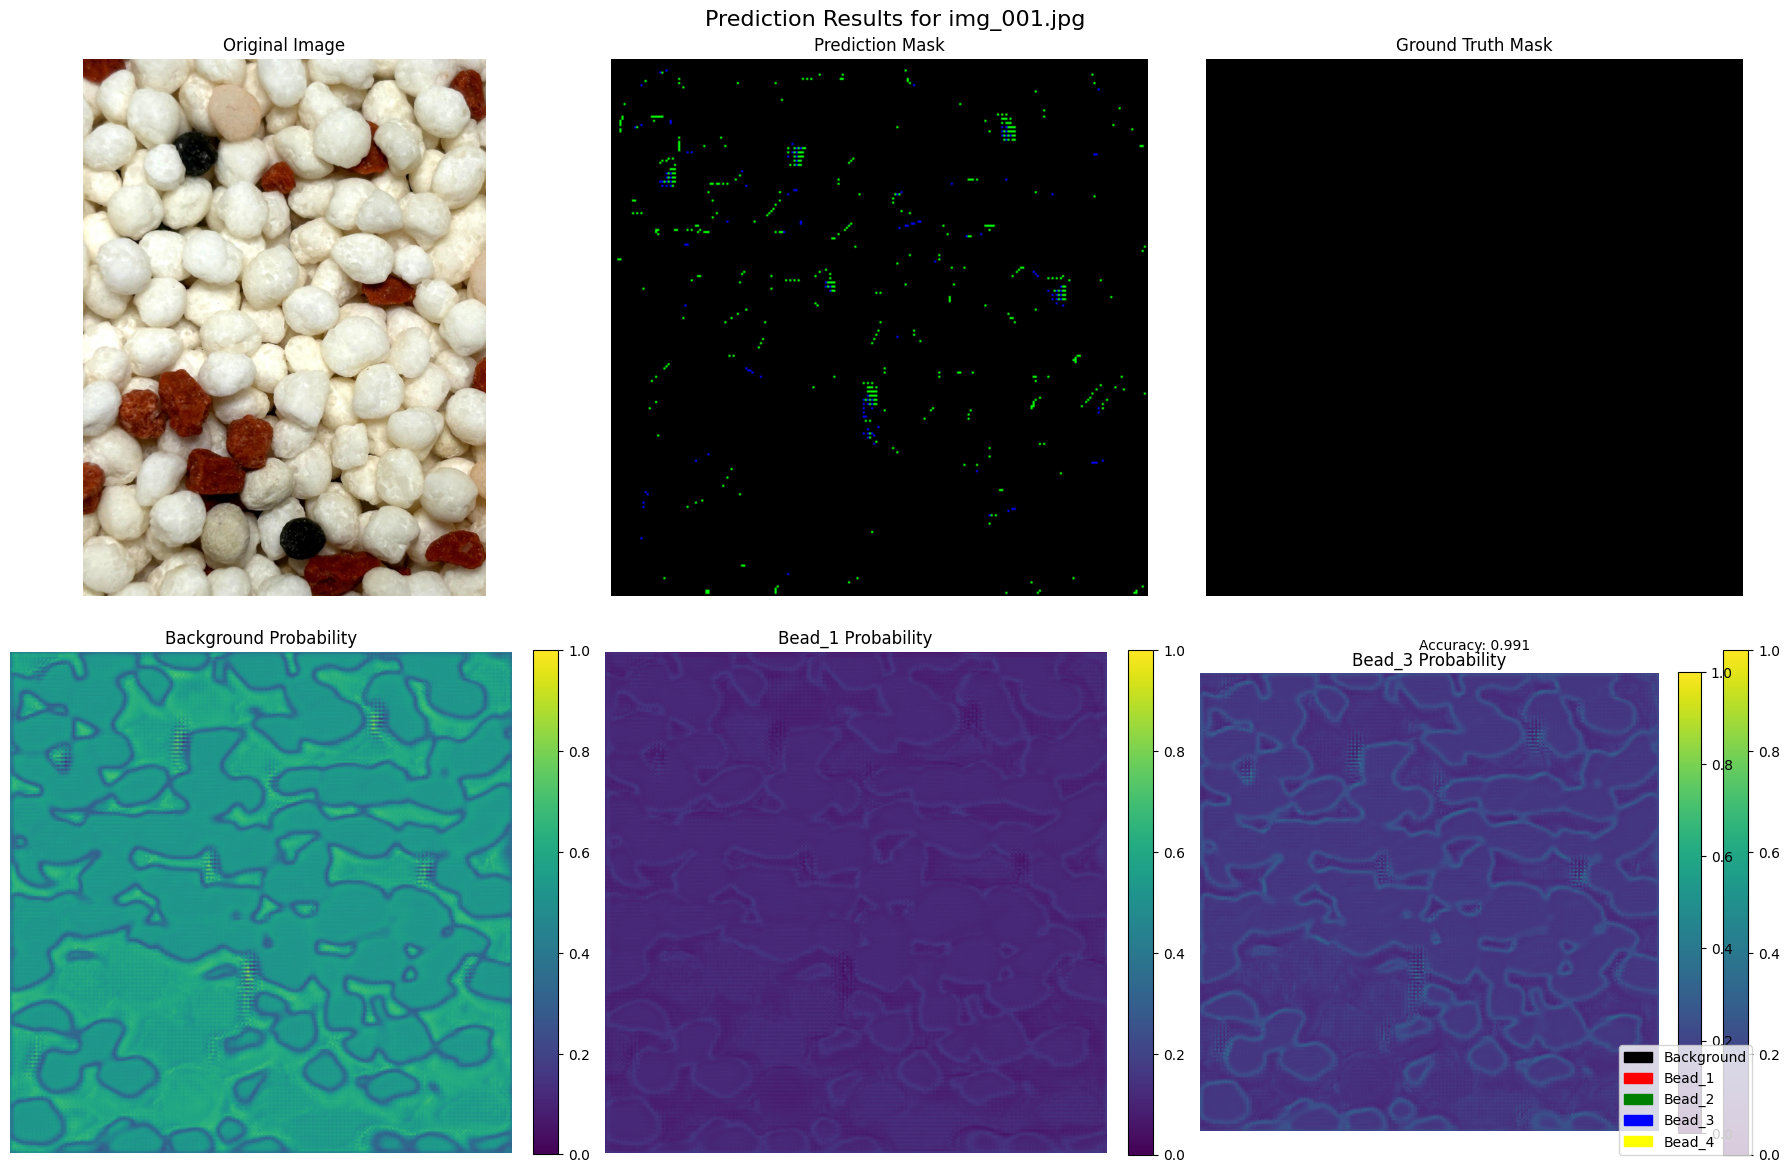

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

class ModelTester:
    """Test and visualize model predictions"""
    
    def __init__(self, model, device, checkpoint_path=None):
        self.model = model
        self.device = device
        
        # Load checkpoint if provided
        if checkpoint_path and os.path.exists(checkpoint_path):
            self.load_checkpoint(checkpoint_path)
        
        self.model.to(device)
        self.model.eval()
        
        # Define class names and colors for visualization
        self.class_names = ['Background', 'Bead_1', 'Bead_2', 'Bead_3', 'Bead_4']
        self.colors = ['black', 'red', 'green', 'blue', 'yellow']
        self.color_map = {i: self.colors[i] for i in range(len(self.class_names))}
    
    def load_checkpoint(self, checkpoint_path):
        """Load model from checkpoint"""
        print(f"Loading checkpoint from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
            if 'best_dice' in checkpoint:
                print(f"Loaded model with best Dice score: {checkpoint['best_dice']:.4f}")
        else:
            self.model.load_state_dict(checkpoint)
        
        print("Checkpoint loaded successfully!")
    
    def predict_single_image(self, image_path, mask_path=None):
        """Make prediction on a single image"""
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        original_size = image.size
        
        # Transform for prediction
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(image).unsqueeze(0).to(self.device)
        
        # Make prediction
        with torch.no_grad():
            output = self.model(input_tensor)
            probabilities = F.softmax(output, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
        
        # Convert back to numpy
        prediction = prediction.cpu().numpy().squeeze()
        probabilities = probabilities.cpu().numpy().squeeze()
        
        # Load ground truth mask if provided
        ground_truth = None
        if mask_path and os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')
            mask_transform = transforms.Compose([
                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
                transforms.ToTensor()
            ])
            ground_truth = mask_transform(mask).squeeze().numpy().astype(np.uint8)
        
        return {
            'original_image': image,
            'prediction': prediction,
            'probabilities': probabilities,
            'ground_truth': ground_truth,
            'original_size': original_size
        }
    
    def visualize_prediction(self, image_path, mask_path=None, save_path=None):
        """Visualize prediction with detailed plots"""
        result = self.predict_single_image(image_path, mask_path)
        
        # Create subplots
        if result['ground_truth'] is not None:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle(f'Prediction Results for {os.path.basename(image_path)}', fontsize=16)
        else:
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))
            fig.suptitle(f'Prediction Results for {os.path.basename(image_path)}', fontsize=16)
        
        # Original image
        axes[0, 0].imshow(result['original_image'])
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Prediction mask
        prediction_colored = self.colorize_mask(result['prediction'])
        axes[0, 1].imshow(prediction_colored)
        axes[0, 1].set_title('Prediction Mask')
        axes[0, 1].axis('off')
        
        # Ground truth (if available)
        if result['ground_truth'] is not None:
            ground_truth_colored = self.colorize_mask(result['ground_truth'])
            axes[0, 2].imshow(ground_truth_colored)
            axes[0, 2].set_title('Ground Truth Mask')
            axes[0, 2].axis('off')
            
            # Calculate and display metrics
            accuracy = np.mean(result['prediction'] == result['ground_truth'])
            axes[0, 2].text(0.5, -0.1, f'Accuracy: {accuracy:.3f}', 
                           transform=axes[0, 2].transAxes, ha='center', fontsize=10)
        
        # Probability maps for each class
        for i in range(min(4, len(result['probabilities']))):
            if result['ground_truth'] is not None:
                row, col = 1, i if i < 3 else 0
                if i == 3:
                    col = 2
                if i >= 3:
                    row = 1
                axis = axes[row, col] if i < 3 else axes[1, 2]
            else:
                row, col = 1, i % 2
                if i >= 2:
                    break
                axis = axes[row, col]
            
            im = axis.imshow(result['probabilities'][i], cmap='viridis', vmin=0, vmax=1)
            axis.set_title(f'{self.class_names[i]} Probability')
            axis.axis('off')
            
            # Add colorbar
            plt.colorbar(im, ax=axis, fraction=0.046, pad=0.04)
        
        # Add legend for classes
        legend_elements = [plt.Rectangle((0,0),1,1, color=self.colors[i], label=self.class_names[i]) 
                          for i in range(len(self.class_names))]
        fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.98, 0.02))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")
        
        plt.show()
        
        return result
    
    def colorize_mask(self, mask):
        """Convert mask to colored visualization"""
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        
        for class_id in range(len(self.class_names)):
            class_mask = (mask == class_id)
            if class_id == 0:  # Background
                colored_mask[class_mask] = [0, 0, 0]
            elif class_id == 1:  # Bead_1
                colored_mask[class_mask] = [255, 0, 0]
            elif class_id == 2:  # Bead_2
                colored_mask[class_mask] = [0, 255, 0]
            elif class_id == 3:  # Bead_3
                colored_mask[class_mask] = [0, 0, 255]
            elif class_id == 4:  # Bead_4
                colored_mask[class_mask] = [255, 255, 0]  # yellow
        
        return colored_mask
    
    def test_random_samples(self, test_loader, num_samples=5):
        """Test on random samples from test loader"""
        # Get random samples
        random_indices = random.sample(range(len(test_loader.dataset)), num_samples)
        
        for i, idx in enumerate(random_indices):
            # Get sample from dataset
            if hasattr(test_loader.dataset, 'dataset'):  # If it's a Subset
                sample = test_loader.dataset.dataset[test_loader.dataset.indices[idx]]
            else:
                sample = test_loader.dataset[idx]
            
            image, mask = sample
            
            # Convert to PIL for visualization
            # Denormalize image
            mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
            denorm_image = image * std + mean
            denorm_image = torch.clamp(denorm_image, 0, 1)
            
            # Convert to numpy
            image_np = denorm_image.permute(1, 2, 0).numpy()
            mask_np = mask.numpy()
            
            # Make prediction
            with torch.no_grad():
                input_tensor = image.unsqueeze(0).to(self.device)
                output = self.model(input_tensor)
                probabilities = F.softmax(output, dim=1)
                prediction = torch.argmax(probabilities, dim=1)
            
            prediction = prediction.cpu().numpy().squeeze()
            probabilities = probabilities.cpu().numpy().squeeze()
            
            # Create visualization
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            fig.suptitle(f'Random Test Sample {i+1}', fontsize=16)
            
            # Original image
            axes[0, 0].imshow(image_np)
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')
            
            # Ground truth
            gt_colored = self.colorize_mask(mask_np)
            axes[0, 1].imshow(gt_colored)
            axes[0, 1].set_title('Ground Truth')
            axes[0, 1].axis('off')
            
            # Prediction
            pred_colored = self.colorize_mask(prediction)
            axes[0, 2].imshow(pred_colored)
            axes[0, 2].set_title('Prediction')
            axes[0, 2].axis('off')
            
            # Calculate accuracy
            accuracy = np.mean(prediction == mask_np)
            axes[0, 2].text(0.5, -0.1, f'Accuracy: {accuracy:.3f}', 
                           transform=axes[0, 2].transAxes, ha='center')
            
            # Probability maps
            for class_id in range(min(3, len(probabilities))):
                im = axes[1, class_id].imshow(probabilities[class_id], cmap='viridis', vmin=0, vmax=1)
                axes[1, class_id].set_title(f'{self.class_names[class_id]} Probability')
                axes[1, class_id].axis('off')
                plt.colorbar(im, ax=axes[1, class_id], fraction=0.046, pad=0.04)
            
            plt.tight_layout()
            plt.show()
    
    def evaluate_on_test_set(self, test_loader):
        """Comprehensive evaluation on test set"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        all_probabilities = []
        
        print("Evaluating on test set...")
        
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(test_loader):
                images = images.to(self.device)
                masks = masks.to(self.device)
                
                # Make predictions
                outputs = self.model(images)
                probabilities = F.softmax(outputs, dim=1)
                predictions = torch.argmax(probabilities, dim=1)
                
                # Store results
                all_predictions.extend(predictions.cpu().numpy().flatten())
                all_targets.extend(masks.cpu().numpy().flatten())
                all_probabilities.extend(probabilities.cpu().numpy())
                
                if batch_idx % 10 == 0:
                    print(f'Batch {batch_idx}/{len(test_loader)}')
        
        # Calculate metrics
        accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))
        
        # Create confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        
        # Plot results
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names,
                   ax=axes[0])
        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        
        # Class-wise accuracy
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        axes[1].bar(self.class_names, class_accuracies, color=self.colors)
        axes[1].set_title('Class-wise Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_ylim(0, 1)
        
        # Add accuracy values on bars
        for i, v in enumerate(class_accuracies):
            axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed report
        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print(f"Mean Class Accuracy: {np.mean(class_accuracies):.4f}")
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions, target_names=self.class_names))
        
        return {
            'accuracy': accuracy,
            'class_accuracies': class_accuracies,
            'confusion_matrix': cm,
            'predictions': all_predictions,
            'targets': all_targets
        }
    
    def compare_predictions(self, image_paths, mask_paths=None):
        """Compare predictions on multiple images"""
        if mask_paths is None:
            mask_paths = [None] * len(image_paths)
        
        num_images = len(image_paths)
        fig, axes = plt.subplots(3, num_images, figsize=(5*num_images, 15))
        
        if num_images == 1:
            axes = axes.reshape(-1, 1)
        
        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            result = self.predict_single_image(img_path, mask_path)
            
            # Original image
            axes[0, i].imshow(result['original_image'])
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Prediction
            pred_colored = self.colorize_mask(result['prediction'])
            axes[1, i].imshow(pred_colored)
            axes[1, i].set_title(f'Prediction {i+1}')
            axes[1, i].axis('off')
            
            # Ground truth or highest probability class
            if result['ground_truth'] is not None:
                gt_colored = self.colorize_mask(result['ground_truth'])
                axes[2, i].imshow(gt_colored)
                axes[2, i].set_title(f'Ground Truth {i+1}')
                
                # Calculate accuracy
                accuracy = np.mean(result['prediction'] == result['ground_truth'])
                axes[2, i].text(0.5, -0.1, f'Acc: {accuracy:.3f}', 
                               transform=axes[2, i].transAxes, ha='center')
            else:
                # Show max probability map
                max_prob = np.max(result['probabilities'], axis=0)
                im = axes[2, i].imshow(max_prob, cmap='viridis', vmin=0, vmax=1)
                axes[2, i].set_title(f'Max Probability {i+1}')
                plt.colorbar(im, ax=axes[2, i], fraction=0.046, pad=0.04)
            
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()


def main():
    """Example usage of the ModelTester"""
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load your model (replace with your actual model)
    # from your_model_file import SimpleUNet
    # model = SimpleUNet(n_classes=4)
    
    # Create tester
    tester = ModelTester(
        model=model,
        device=device,
        checkpoint_path='checkpoints/best_model.pth'  # Path to your checkpoint
    )
    
    # Test single image
    image_path = 'UNET_dataset/images/img_001.jpg'
    mask_path = 'UNET_dataset/masks/img_001.png'  # Optional
    
    result = tester.visualize_prediction(image_path, mask_path)
    
    # Test random samples (if you have test_loader)
    # tester.test_random_samples(test_loader, num_samples=3)
    
    # Full evaluation on test set
    # evaluation_results = tester.evaluate_on_test_set(test_loader)
    
    # Compare multiple images
    # image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
    # mask_paths = ['mask1.png', 'mask2.png', 'mask3.png']
    # tester.compare_predictions(image_paths, mask_paths)


if __name__ == "__main__":
    main()